# LQ-optimal regulator design for F16 lateral-directional dynamics

## Building a continuous-time linear state-space model for the system

Example 5.3-1 from [Stevens & Lewis, 3rd ed., 2015](https://www.wiley.com/en-us/Aircraft+Control+and+Simulation%3A+Dynamics%2C+Controls+Design%2C+and+Autonomous+Systems%2C+3rd+Edition-p-9781118870983), page 407. Linear model of lateral-directional dynamics of F16 trimmed at: VT=502ft/s, 302psf dynamic pressure, cg @ 0.35cbar. Includes dynamics of ailerons and rudders and washout filter.

<img src=f16_lqr.png width=800px>

| Symbol        | Name           | Units  |
|:--------------|:---------------|:------:|
| β             | sideslip angle |  rad   |
| ϕ             | bank angle     |  rad   |
| p             | roll rate      |  rad/s |
| r             | yaw rate       |  rad/s |

In [1]:
A = [-0.3220  0.0640   0.0364    -0.9917    0.0003     0.0008   0;
    0         0        1         0.0037     0          0        0;
    -30.6492  0        -3.6784   0.6646     -0.7333    0.1315   0;
    8.5396    0        -0.0254   -0.4764    -0.0319    -0.062   0;
    0         0        0         0          -20.2      0        0;
    0         0        0         0          0          -20.2    0;
    0         0        0         57.2958    0          0       -1];

B = [0     0;
    0      0;
    0      0;
    0      0;
    20.2   0;
    0      20.2;
    0      0];

C = [0      0       0       57.2958 0      0    -1;
    0       0       57.2958 0       0      0     0;
    57.2958 0       0       0       0      0     0;
    0       57.2958 0       0       0      0     0];

The `C` matrix converts from radians to degrees.

In [2]:
using ControlSystems, LinearAlgebra

┌ Info: Precompiling ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]
└ @ Base loading.jl:1273


In [3]:
G = ss(A,B,C,0);

## Conversion of the model to discrete time 

In [4]:
Ts = 0.1;                     # sampling period
Gd,x0map = c2d(G,Ts);         # discretized system
A,B,C,D = Gd.A,Gd.B,Gd.C,Gd.D

([0.9226667967276305 0.0061993687563318516 … 0.0002121726335909019 0.0; -0.1324663143618211 0.9997066454002713 … 0.00031188493568957813 0.0; … ; 0.0 0.0 … 0.13265546508012172 0.0; 2.292290658677099 0.004976965360488232 … -0.009375212477843127 0.9048374180359594], [2.821613795894789e-5 0.00018468401795193422; -0.001449606139792144 0.0002532096035015619; … ; 0.0 0.8673445349198781; -0.0037522412534400328 -0.007373986216857328], [0.0 0.0 … 0.0 -1.0; 0.0 0.0 … 0.0 0.0; 57.2958 0.0 … 0.0 0.0; 0.0 57.2958 … 0.0 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0])

## Setting the weights for the LQ controller

In [5]:
q_beta = 100.0;
q_phi = 100;
q_p = 1;
q_r = 1;
q_rw = 1;

r_a = 1;
r_r = 1;

In [6]:
q = [q_beta, q_phi, q_p, q_r, 0, 0, q_rw];
r = [r_a, r_r];

In [7]:
Q = diagm(0=>q)

7×7 Array{Float64,2}:
 100.0    0.0  0.0  0.0  0.0  0.0  0.0
   0.0  100.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0  1.0  0.0  0.0  0.0  0.0
   0.0    0.0  0.0  1.0  0.0  0.0  0.0
   0.0    0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0  0.0  0.0  0.0  0.0  1.0

In [8]:
R = diagm(0=>r)

2×2 Array{Int64,2}:
 1  0
 0  1

## Checking controllability and observability conditions for existence of a unique stabilizing solution to ARE

Check the controllability and observability condition

In [9]:
rank(ctrb(A,B))

7

In [10]:
rank(obsv(A,Q))

7

## Solving the discrete-time ARE

In [11]:
S = dare(A,B,Q,R)

7×7 Array{Float64,2}:
 22917.0      -709.469      -79.0765     …  -3.10458     198.503    
  -709.469     778.937      130.822          0.170749      0.0897329
   -79.0765    130.822       30.1433         0.0581277     0.776192 
   551.178     223.96        44.4488        -4.32512      33.617    
     2.12913    -4.72131     -1.0744         0.00463419   -0.0687775
    -3.10458     0.170749     0.0581277  …   0.0133334    -0.0845118
   198.503       0.0897329    0.776192      -0.0845118     5.27494  

## Forming a feedback gain matrix based on the solution to ARE

In [12]:
K = (R+B'*S*B)\B'*S*A

2×7 Array{Float64,2}:
  3.83005  -8.71416   -2.04247   -7.63013  0.0834495   0.00929287  -0.119255
 -9.79641   0.392317   0.126108  -8.26172  0.00832575  0.0260754   -0.157085

Alternatively, we could use the higher-level `lqr` or `dlqr` functions

In [13]:
#K = lqr(Gd,Q,R)
#K = dlqr(A,B,Q,R) # note that here A and B correspond to the discrete-time model

## Simulating the response to nonzero initial conditions

In [14]:
u(x,t) = -K*x # Control law

u (generic function with 1 method)

In [15]:
t=0:Ts:10.0
x0 = [1/10, 0, 0, 0, 0, 0, 0]

7-element Array{Float64,1}:
 0.1
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
y, t, x, uout = lsim(Gd,u,t,x0=x0)

([0.0 0.0 5.72958 0.0; 4.267905268917968 -12.90044103629656 5.296240221889117 -0.7129528775280597; … ; -0.0034802880589172285 -0.005099672191666195 0.003376010636662276 0.00813730111730901; 0.0005185258900812493 -0.012254500541743095 0.0037606824792750233 0.007251190956686843], 0.0:0.1:10.0, [0.1 0.0 … 0.0 0.0; 0.09243679679643389 -0.01244337067512906 … 0.8496862981097764 0.22344233313213632; … ; 5.8922480123539175e-5 0.00014202264594104645 … -0.0016104165385973596 -0.003387682516009194; 6.56362679162351e-5 0.00012655711163273473 … -0.0010322451218726303 -0.0035321440380412135], [-0.3830048919511592 0.97964103525281; -0.27775415596125824 1.6021594916142818; … ; -0.0004341174806268835 -0.0009438170577138625; -0.0003617095226485118 -0.00033849834576412893])

## Plotting the simulation outcomes

In [17]:
using Plots, LaTeXStrings

In [18]:
pyplot()

Plots.PyPlotBackend()

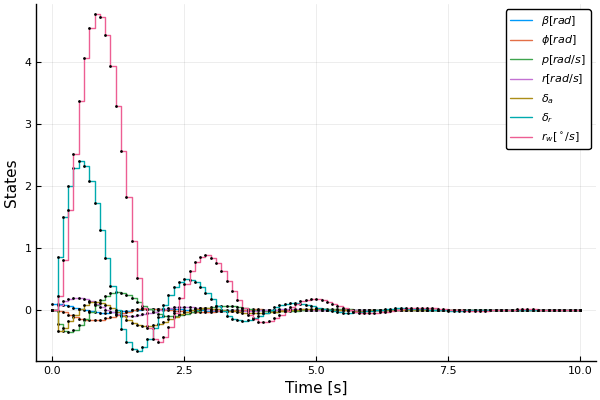

In [19]:
plot(t,x, label=[L"\beta [rad]" L"\phi [rad]" L"p [rad/s]" L"r [rad/s]" L"\delta_a" L"\delta_r" L"r_w [^\circ/s]"], xlabel="Time [s]", ylabel="States",markershape=:circle,markersize=1,linetype=:steppost)

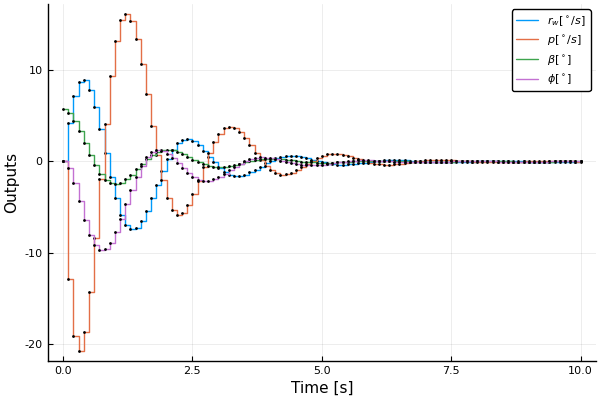

In [20]:
plot(t,y, label=[L"r_w [^\circ/s]" L"p [^\circ/s]" L"\beta [^\circ]" L"\phi [^\circ]"], xlabel="Time [s]", ylabel="Outputs",markershape=:circle,markersize=1,linetype=:steppost)